# Proyecto 2
## 1. Preparando los datos.
Los datos se descargan en [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

In [676]:
#Preparando las bibliotecas a utilizar
import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib as mpl
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
import random

In [677]:
#Leyendo los datos a utilizar
data = pd.read_csv('../Datos/train.csv')
test_data = pd.read_csv('../Datos/test.csv')

Una vez leidos los datos se procede a dar un vistazo de
las variables que contiene. En este caso vemos que se trata de
una base de datos de **1460** registros y **80**
variables. Además se identifica la variable objetivo como **SalePrice**, por lo que quedan **79** variables
como posibles predictoras.



In [678]:
data.shape

(1460, 81)

In [679]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

De estas 79 variables hay algunas que en particular llaman mucho la atención, debido a la gran
cantidad de valores con NAN.
Estas son:

- Alley
- FireplaceQu
- PoolQC
- Fence
- MiscFeature

Estas deberán ser estudiadas a detalle antes de realizar los modelos.

Ahora vamos a separar las varibles según su tipo de dato. Vemos que los tres tipos presentes son:
- float64: variables continuas.
- int64: variables enteras (posiblemente son ordinales).
- object: variables cualitativas.

Se hace la unión de los datos de entrenamiento con los datos de test, esto debido a que se
hace más fácil manejarlo de esta manera.

In [680]:
y = data.SalePrice
data_train = data.drop("SalePrice", axis = 1)
data = pd.concat([data, test_data], keys=["train", "test"])
data.tail()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley  \
test 1454  2915         160       RM         21.0     1936   Pave   NaN   
     1455  2916         160       RM         21.0     1894   Pave   NaN   
     1456  2917          20       RL        160.0    20000   Pave   NaN   
     1457  2918          85       RL         62.0    10441   Pave   NaN   
     1458  2919          60       RL         74.0     9627   Pave   NaN   

          LotShape LandContour Utilities  ... PoolArea PoolQC  Fence  \
test 1454      Reg         Lvl    AllPub  ...        0    NaN    NaN   
     1455      Reg         Lvl    AllPub  ...        0    NaN    NaN   
     1456      Reg         Lvl    AllPub  ...        0    NaN    NaN   
     1457      Reg         Lvl    AllPub  ...        0    NaN  MnPrv   
     1458      Reg         Lvl    AllPub  ...        0    NaN    NaN   

          MiscFeature MiscVal MoSold YrSold  SaleType  SaleCondition  \
test 1454         NaN       0      6   2006        WD         Normal   
     1455         NaN       0      4   2006        WD        Abnorml   
     1456         NaN       0      9   2006        WD        Abnorml   
     1457        Shed     700      7   2006        WD         Normal   
     1458         NaN       0     11   2006        WD         Normal   

           SalePrice  
test 1454        NaN  
     1455        NaN  
     1456        NaN  
     1457        NaN  
     1458        NaN  

[5 rows x 81 columns]

In [681]:
data = data.drop('Id', axis=1)
test_data = test_data.drop('Id', axis=1)
continuas = []
enteras = []
object = []
for feature in data.columns:
    if str(data[feature].dtype) == "float64":
        continuas.append(feature)
    elif str(data[feature].dtype) == "int64":
        enteras.append(feature)
    elif str(data[feature].dtype) == "object":
        object.append(feature)

print(continuas)
print(enteras)
print(object)



['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'SalePrice']
['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQua

En este caso las tres variables continuas se verifican como continuas, incluida *GarageYrBlt*.
Se clasifican las variables cualitativas en ordinales, nominales y dicotómicas.

In [682]:

continuas = continuas + ["LowQualFinSF",
                         "3SsnPorch","PoolArea","MiscVal","YrSold"
                         ]

nominales = ["YearRemodAdd", "MSSubClass","MoSold",
             "MSZoning","Street","Alley","LotShape","LandContour",
             "Utilities", "LotConfig", "LandSlope", "Neighborhood",
             "Condition1", "Condition2","BldgType", "HouseStyle",
             "RoofStyle", "RoofMatl", "Exterior1st","Exterior2nd",
             "MasVnrType","Foundation","Heating", "Electrical",
             "Functional","GarageType","PavedDrive","Fence",
             "MiscFeature","SaleType","SaleCondition"
             ]
ordinal = ["OverallQual", "OverallCond", "BsmtFullBath",
           "BsmtHalfBath","FullBath","HalfBath","BedroomAbvGr",
           "KitchenAbvGr",
           "TotRmsAbvGrd",
           "Fireplaces",
           "GarageCars",
           "ExterQual",
           "ExterCond",
           "BsmtQual",
           "BsmtCond",
           "BsmtExposure",
           "BsmtFinType2",
           "HeatingQC",
           "KitchenQual",
           "FireplaceQu",
           "GarageFinish",
           "GarageQual",
           "GarageCond",
           "PoolQC"]

dicotomicas = ["CentralAir",]
print(data.YearBuilt.nunique())
print(data.YearRemodAdd.nunique())
print(data.BsmtFinSF1.nunique())
print(data.BsmtFinSF2.nunique())

#Viendo por número de categorías
for x in  enteras:
    if data[x].nunique() < 50:
        print(x, data[x].nunique() )
print("********Object*********")
for x in  object:
    if data[x].nunique() < 50:
        print(x, data[x].nunique() )
print("********Features con 50 categorías o más*****")
for x in  enteras:
    if data[x].nunique() >= 50:
        print(x, data[x].nunique() )
        if x not in continuas:
            continuas.append(x)
            data[x] = pd.to_numeric(data[x])
print("********Object*********")
for x in  object:
    if data[x].nunique() >= 50:
        print(x, data[x].nunique() )
        if x not in continuas:
            continuas.append(x)
continuas.remove("SalePrice")

print("Continuas", len(continuas))
print("Dicotomicas", len(dicotomicas))
print("Nominales", len(nominales))
print("Ordinales", len(ordinal))
print("En total hay", len(continuas + dicotomicas + nominales + ordinal) , "features")

118
61
991
272
MSSubClass 16
OverallQual 10
OverallCond 9
LowQualFinSF 36
FullBath 5
HalfBath 3
BedroomAbvGr 8
KitchenAbvGr 4
TotRmsAbvGrd 14
Fireplaces 5
3SsnPorch 31
PoolArea 14
MiscVal 38
MoSold 12
YrSold 5
********Object*********
MSZoning 5
Street 2
Alley 2
LotShape 4
LandContour 4
Utilities 2
LotConfig 5
LandSlope 3
Neighborhood 25
Condition1 9
Condition2 8
BldgType 5
HouseStyle 8
RoofStyle 6
RoofMatl 8
Exterior1st 15
Exterior2nd 16
MasVnrType 4
ExterQual 4
ExterCond 5
Foundation 6
BsmtQual 4
BsmtCond 4
BsmtExposure 4
BsmtFinType1 6
BsmtFinType2 6
Heating 6
HeatingQC 5
CentralAir 2
Electrical 5
KitchenQual 4
Functional 7
FireplaceQu 5
GarageType 6
GarageFinish 3
GarageQual 5
GarageCond 5
PavedDrive 3
PoolQC 3
Fence 4
MiscFeature 4
SaleType 9
SaleCondition 6
********Features con 50 categorías o más*****
LotArea 1951
YearBuilt 118
YearRemodAdd 61
1stFlrSF 1083
2ndFlrSF 635
GrLivArea 1292
WoodDeckSF 379
OpenPorchSF 252
EnclosedPorch 183
ScreenPorch 121
********Object*********
Continu

Ahora se revisa los tipos de las variables para ver si son congruentes con su categorización.
Se convierten algunas variables enteras a cadena.

In [683]:
data[continuas].info()
data[dicotomicas].info()
data[nominales].info()
data[ordinal].info()

for x in nominales:
    if data[x].dtype != "object":
        data[x] = data[x].apply(str)

data["YearRemodAdd"] = data["YearRemodAdd"].apply(pd.to_numeric)
data["YrSold"] = data["YrSold"].apply(pd.to_numeric)

print("************Continuas")
data[continuas].info()
print("**********Dicotomicas")
data[dicotomicas].info()
print("**********Nominales")
data[nominales].info()
print("***********Ordinales")
data[ordinal].info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2919 entries, ('train', 0) to ('test', 1458)
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LotFrontage    2433 non-null   float64
 1   MasVnrArea     2896 non-null   float64
 2   BsmtFinSF1     2918 non-null   float64
 3   BsmtFinSF2     2918 non-null   float64
 4   BsmtUnfSF      2918 non-null   float64
 5   TotalBsmtSF    2918 non-null   float64
 6   BsmtFullBath   2917 non-null   float64
 7   BsmtHalfBath   2917 non-null   float64
 8   GarageYrBlt    2760 non-null   float64
 9   GarageCars     2918 non-null   float64
 10  GarageArea     2918 non-null   float64
 11  LowQualFinSF   2919 non-null   int64  
 12  3SsnPorch      2919 non-null   int64  
 13  PoolArea       2919 non-null   int64  
 14  MiscVal        2919 non-null   int64  
 15  YrSold         2919 non-null   int64  
 16  LotArea        2919 non-null   int64  
 17  YearBuilt      2919 non-null   

Revisando las variables en busca de NA para comprender mejor la situación. Para ello
primero vamos a calcular los porcentajes de NA en cada variable.

In [684]:
porcentajes = {}
for column in list(data.columns):
    porcentajes[column] = len(data[column][data[column].isna()==True]) / len(data[column]) *100
sorted(porcentajes.items(), key=lambda x:x[1])


[('MSSubClass', 0.0),
 ('LotArea', 0.0),
 ('Street', 0.0),
 ('LotShape', 0.0),
 ('LandContour', 0.0),
 ('LotConfig', 0.0),
 ('LandSlope', 0.0),
 ('Neighborhood', 0.0),
 ('Condition1', 0.0),
 ('Condition2', 0.0),
 ('BldgType', 0.0),
 ('HouseStyle', 0.0),
 ('OverallQual', 0.0),
 ('OverallCond', 0.0),
 ('YearBuilt', 0.0),
 ('YearRemodAdd', 0.0),
 ('RoofStyle', 0.0),
 ('RoofMatl', 0.0),
 ('ExterQual', 0.0),
 ('ExterCond', 0.0),
 ('Foundation', 0.0),
 ('Heating', 0.0),
 ('HeatingQC', 0.0),
 ('CentralAir', 0.0),
 ('1stFlrSF', 0.0),
 ('2ndFlrSF', 0.0),
 ('LowQualFinSF', 0.0),
 ('GrLivArea', 0.0),
 ('FullBath', 0.0),
 ('HalfBath', 0.0),
 ('BedroomAbvGr', 0.0),
 ('KitchenAbvGr', 0.0),
 ('TotRmsAbvGrd', 0.0),
 ('Fireplaces', 0.0),
 ('PavedDrive', 0.0),
 ('WoodDeckSF', 0.0),
 ('OpenPorchSF', 0.0),
 ('EnclosedPorch', 0.0),
 ('3SsnPorch', 0.0),
 ('ScreenPorch', 0.0),
 ('PoolArea', 0.0),
 ('MiscVal', 0.0),
 ('MoSold', 0.0),
 ('YrSold', 0.0),
 ('SaleCondition', 0.0),
 ('Exterior1st', 0.03425830763960

En este análisis se puede ver que hay columnas con 5.54% de datos con NAN y luego el número que les sigue es 17.73%
(LotFrontAge). Hacemos un análisis junto con el diccionario de variables y vemos que:
- LotFrontage: es una variable continua, al no haber dato no se puede inferir nada.
- FireplaceQu: es una variable ordinal. NA significa que la casa no tiene chimenea. En este caso esta variable podría ser
recodificada.
- Fence: Fence quality, variable ordinal. NA significa que la casa no tiene cerca. Al igual que el caso anterior la variable
podría ser recodificada.
- Alley: esta variable es nominal y el tipo de material del callejon. NA significa que la casa no tiene callejón aledaño.
La variable puede ser recodificada.
- MiscFeature: esta variable describe comodidades extras del hogar. El NA indica que la casa no tiene extras de lujo.
Esta variable también se podría recodificar.
- PoolQC: variable ordinal que describe la calidad de la piscina. NA se pone en caso la casa no tiene piscina. Esta variable
es candidata a ser recodificada.

Con esto, resulta conveniente graficar estas variables para ver su comportamiento.



['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']
Alley
FireplaceQu
PoolQC
Fence
MiscFeature


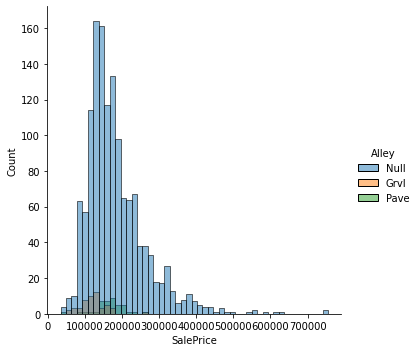

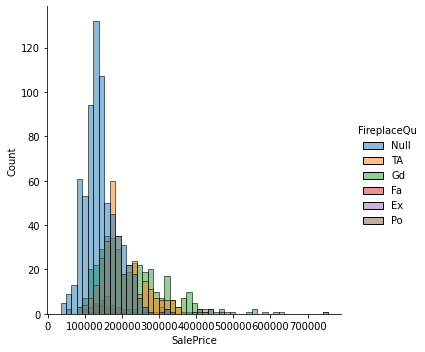

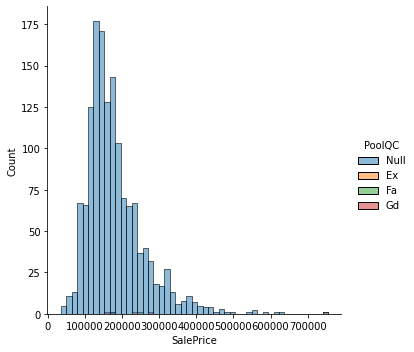

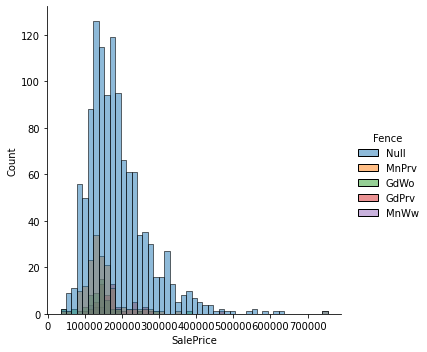

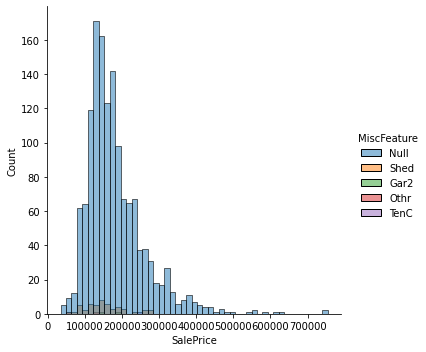

In [685]:
columnas_candidatas = []
for x in porcentajes:
    if porcentajes[x] >=10:
        columnas_candidatas.append(x)

columnas_candidatas.remove("SalePrice")

columnas_candidatas = columnas_candidatas[1:]
print(columnas_candidatas)
for col in columnas_candidatas:
    training_recodificados = data.copy()
    training_recodificados[col] = training_recodificados[col].fillna("Null")
    categorias = training_recodificados[col].value_counts().index.tolist()
    kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})
    dato = training_recodificados.loc[training_recodificados[col] == x,"SalePrice" ]
    print(col)
    sb.displot(training_recodificados, x = "SalePrice", hue = col)


Vemos en las gráficas que en el caso de estas variables, el problema se arregla agregando una
categoría más en lugar del NA. Esto debido a que se trata de variables descriptoras de calidad, así que cuando
se encuentra un NA esto significa que la casa no tiene esa funcionalidad o ambiente, por lo que se
se consignará de esa manera. Esto también conlleva a que estas variables que antes habían sido catalogadas
como ordinales, ahora pasaran a ser variables nominales.


Histograma después de imputación


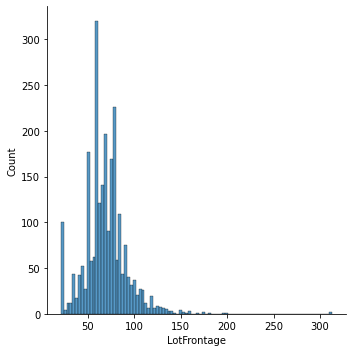

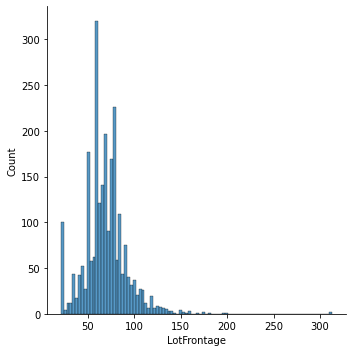

In [686]:
sb.displot(data, x = "LotFrontage")
'''
training_recodificados.LotFrontage = np.where(data.LotFrontage.isnull(),1,0)
sb.displot(training_recodificados, x="SalePrice", hue="LotFrontage")
'''



imputer = SimpleImputer(missing_values= np.nan , strategy="mean")
imputer = imputer.fit(data[["LotFrontage"]])
data.LotFrontage = imputer.transform(data[["LotFrontage"]])
print("Histograma después de imputación")
sb.displot(training_recodificados, x = "LotFrontage")

In [687]:
#Haciendo imputación
'''
for x in features_imputacion:
    imputer = SimpleImputer(missing_values= np.nan , strategy="mean")
    imputer = imputer.fit(data[[x]])
    training_recodificados.LotFrontage = imputer.transform(data[[x]])
    print("Histograma después de imputación")
    sb.displot(training_recodificados, x = "LotFrontage")
'''


'\nfor x in features_imputacion:\n    imputer = SimpleImputer(missing_values= np.nan , strategy="mean")\n    imputer = imputer.fit(data[[x]])\n    training_recodificados.LotFrontage = imputer.transform(data[[x]])\n    print("Histograma después de imputación")\n    sb.displot(training_recodificados, x = "LotFrontage")\n'

In [688]:
data.FireplaceQu = data.FireplaceQu.fillna("NF")
data.Fence =data.Fence.fillna("NFe")
data.Alley = data.Alley.fillna("NoAlley")
data.MiscFeature = data.MiscFeature.fillna("NoMiscFeature")
data.PoolQC = data.PoolQC.fillna("NoP")



Recodificando y haciendo imputaciones para el resto de las variables (cuyos porcentajes de NA fueron
menor a 10%).

In [689]:
features_imputacion = []
for x in porcentajes:
    if porcentajes[x] <10 and porcentajes[x] >0:
        features_imputacion.append(x)
        print(x, porcentajes[x])
print(features_imputacion)

data.MasVnrType = data.MasVnrType.fillna("NoMasonry")
data.MasVnrArea =data.MasVnrArea.fillna(0)
data.BsmtQual = data.BsmtQual.fillna("NB") #Cambiar a nominal
data.BsmtCond = data.BsmtCond.fillna("NB") #Cambiar a nominal
data.BsmtExposure = data.BsmtExposure.fillna("NB") #Cambiar a nominales
data.BsmtFinType1 = data.BsmtFinType1.fillna("NB") #Cambiar a nominales
data.BsmtFinType2 = data.BsmtFinType2.fillna("NB") #Cambiar a nominal
#Con electrical el dato si está perdido, se sugiere perder esos registros
data.GarageType = data.GarageType.fillna("NG")
#Imputación
imputer = SimpleImputer(missing_values= np.nan , strategy="mean")
imputer = imputer.fit(data[["GarageYrBlt"]])
data.GarageYrBlt = imputer.transform(data[["GarageYrBlt"]])
#***
data.GarageFinish = data.GarageFinish.fillna("NG") #Cambiar a nominal si necesario
data.GarageQual = data.GarageQual.fillna("NG") #Cambiar a nominales
data.GarageCond = data.GarageCond.fillna("NG") #Cambiar a nominal

data.dropna(inplace=True)
print(data.shape)

porcentajes = {}
for column in list(data.columns):
    porcentajes[column] = len(data[column][data[column].isna()==True]) / len(data[column]) *100
sorted(porcentajes.items(), key=lambda x:x[1])


MSZoning 0.1370332305584104
Utilities 0.0685166152792052
Exterior1st 0.0342583076396026
Exterior2nd 0.0342583076396026
MasVnrType 0.8221993833504625
MasVnrArea 0.7879410757108599
BsmtQual 2.774922918807811
BsmtCond 2.8091812264474134
BsmtExposure 2.8091812264474134
BsmtFinType1 2.7064063035286057
BsmtFinSF1 0.0342583076396026
BsmtFinType2 2.7406646111682083
BsmtFinSF2 0.0342583076396026
BsmtUnfSF 0.0342583076396026
TotalBsmtSF 0.0342583076396026
Electrical 0.0342583076396026
BsmtFullBath 0.0685166152792052
BsmtHalfBath 0.0685166152792052
KitchenQual 0.0342583076396026
Functional 0.0685166152792052
GarageType 5.378554299417608
GarageYrBlt 5.4470709146968135
GarageFinish 5.4470709146968135
GarageCars 0.0342583076396026
GarageArea 0.0342583076396026
GarageQual 5.4470709146968135
GarageCond 5.4470709146968135
SaleType 0.0342583076396026
['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', '

[('MSSubClass', 0.0),
 ('MSZoning', 0.0),
 ('LotFrontage', 0.0),
 ('LotArea', 0.0),
 ('Street', 0.0),
 ('Alley', 0.0),
 ('LotShape', 0.0),
 ('LandContour', 0.0),
 ('Utilities', 0.0),
 ('LotConfig', 0.0),
 ('LandSlope', 0.0),
 ('Neighborhood', 0.0),
 ('Condition1', 0.0),
 ('Condition2', 0.0),
 ('BldgType', 0.0),
 ('HouseStyle', 0.0),
 ('OverallQual', 0.0),
 ('OverallCond', 0.0),
 ('YearBuilt', 0.0),
 ('YearRemodAdd', 0.0),
 ('RoofStyle', 0.0),
 ('RoofMatl', 0.0),
 ('Exterior1st', 0.0),
 ('Exterior2nd', 0.0),
 ('MasVnrType', 0.0),
 ('MasVnrArea', 0.0),
 ('ExterQual', 0.0),
 ('ExterCond', 0.0),
 ('Foundation', 0.0),
 ('BsmtQual', 0.0),
 ('BsmtCond', 0.0),
 ('BsmtExposure', 0.0),
 ('BsmtFinType1', 0.0),
 ('BsmtFinSF1', 0.0),
 ('BsmtFinType2', 0.0),
 ('BsmtFinSF2', 0.0),
 ('BsmtUnfSF', 0.0),
 ('TotalBsmtSF', 0.0),
 ('Heating', 0.0),
 ('HeatingQC', 0.0),
 ('CentralAir', 0.0),
 ('Electrical', 0.0),
 ('1stFlrSF', 0.0),
 ('2ndFlrSF', 0.0),
 ('LowQualFinSF', 0.0),
 ('GrLivArea', 0.0),
 ('BsmtFul

## 2. Explorando los datos
En esta parte se hará una exploración de los datos para ganar un poco de intuición a cerca de
como se comportan las variables.


In [690]:
data.describe()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrSold,SalePrice
count,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,...,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,69.915833,10517.363948,6.100069,5.575737,1971.244003,1984.850583,103.187800,443.943797,46.581220,567.366004,...,473.030158,94.240576,46.692255,21.969157,3.411926,15.071282,2.760795,43.518849,2007.815627,180930.394791
std,22.033263,9984.666267,1.383171,1.113079,30.199555,20.644343,180.773158,456.106417,161.369977,441.992392,...,213.869604,125.381679,66.267472,61.137400,29.327247,55.775138,40.191018,496.291826,1.328542,79468.964025
min,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2006.000000,34900.000000
25%,60.000000,7549.000000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,...,333.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2007.000000,129950.000000
50%,69.305795,9477.000000,6.000000,5.000000,1973.000000,1994.000000,0.000000,384.000000,0.000000,479.000000,...,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2008.000000,163000.000000
75%,79.000000,11603.000000,7.000000,6.000000,2000.000000,2004.000000,164.500000,712.500000,0.000000,808.000000,...,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2009.000000,214000.000000
max,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,...,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,2010.000000,755000.000000


In [691]:
y = data.SalePrice
target = data.copy()
target = target.drop(['SalePrice'], axis=1)

Construyendo histogramas para las variables numéricas para ver su comportamiento

/home/hugog/GitHub/Proyecto2---Inteligencia-Artificial/venv/lib/python3.9/site-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


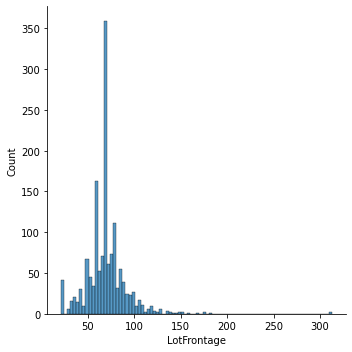

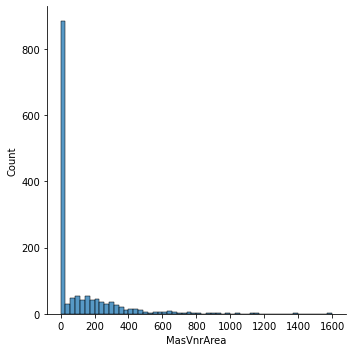

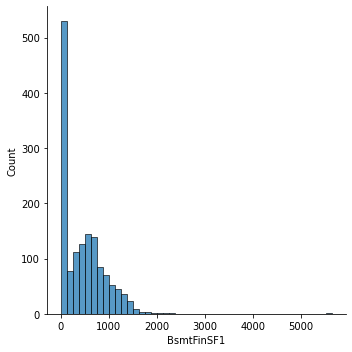

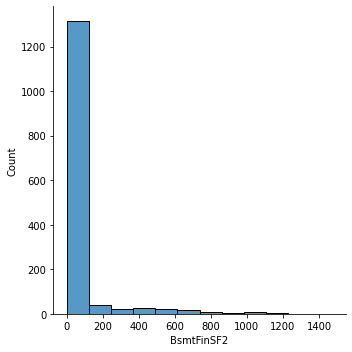

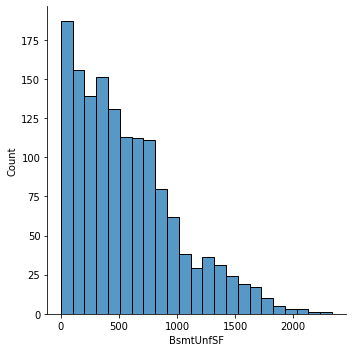

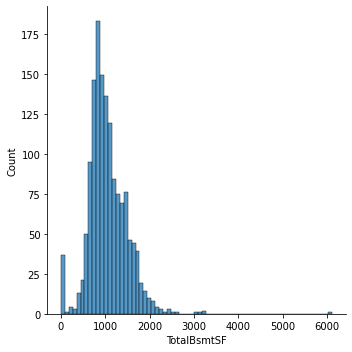

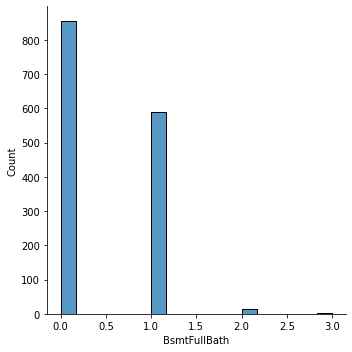

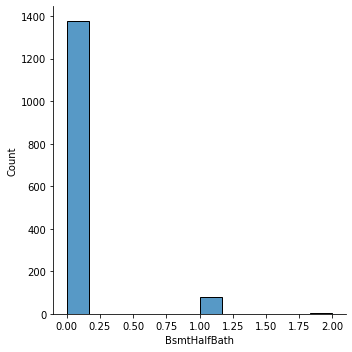

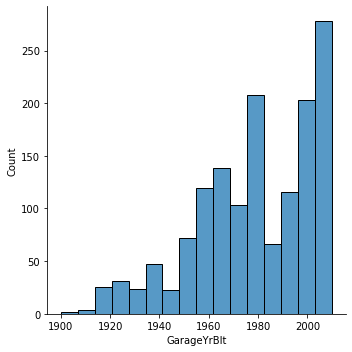

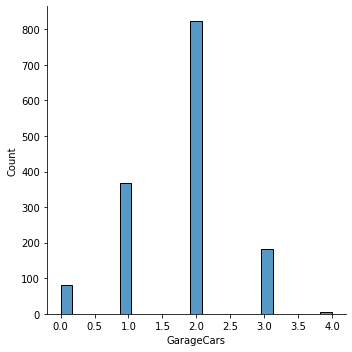

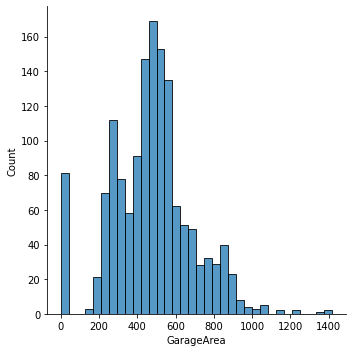

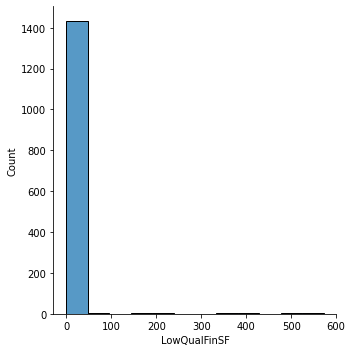

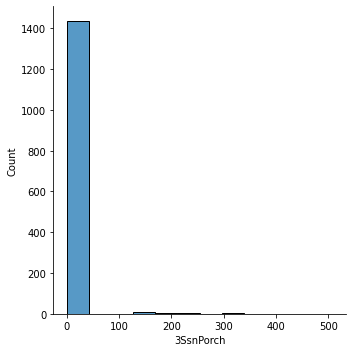

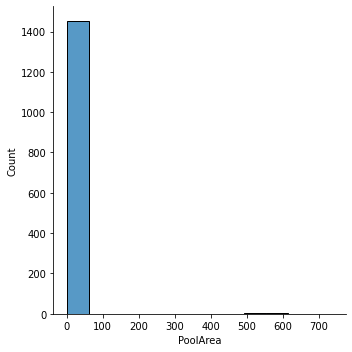

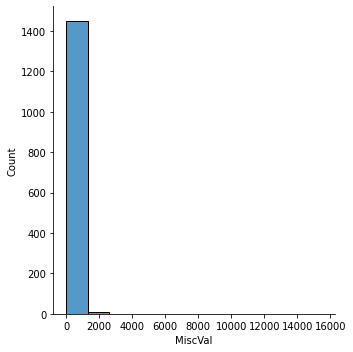

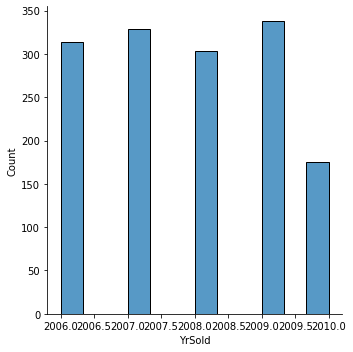

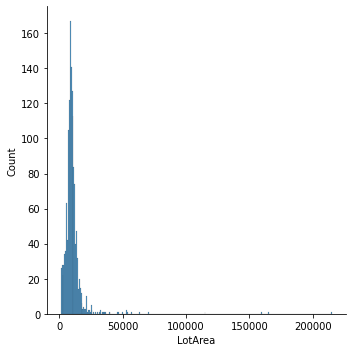

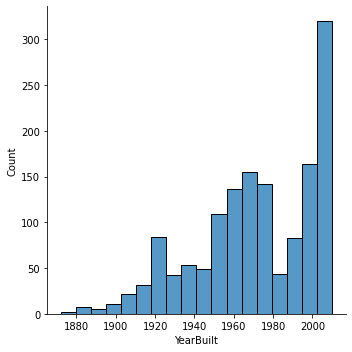

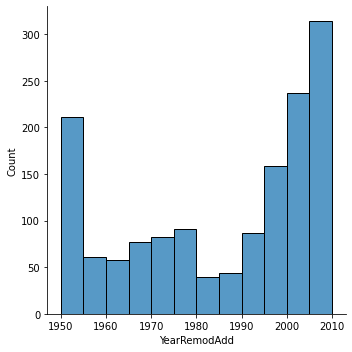

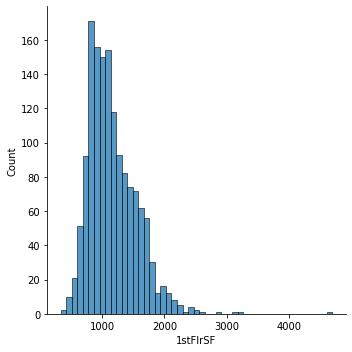

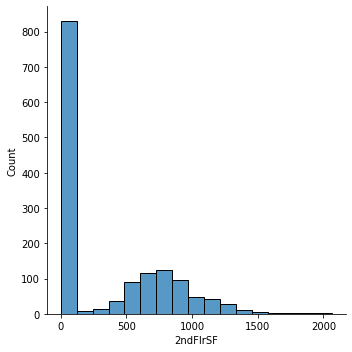

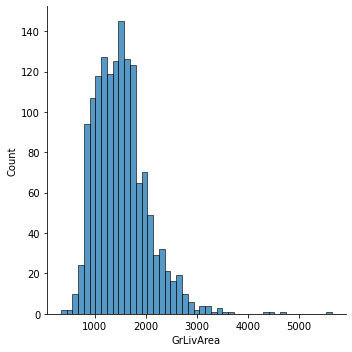

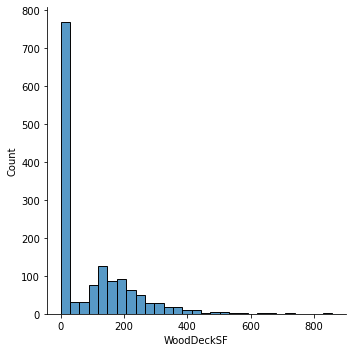

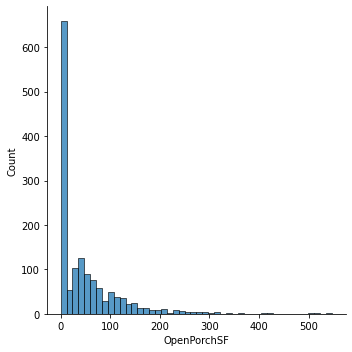

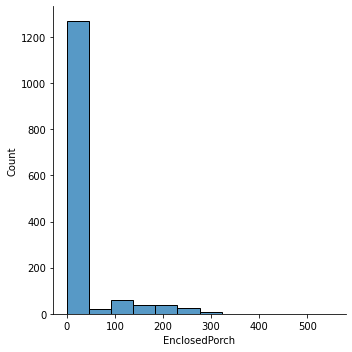

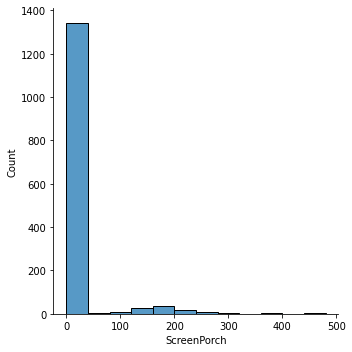

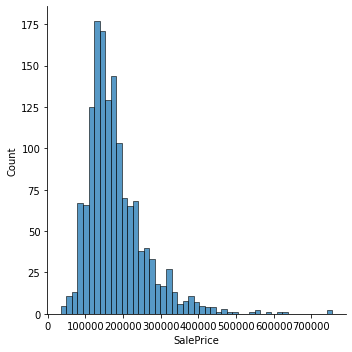

In [692]:
for x in continuas:
    sb.displot(target, x = x)
sb.displot(data, x = y)

Se puede apreciar gráficas en donde se distribuyen muy bien los datos y otras donde no tanto.
En particular, se observa que la distribución de la variable objetivo (SalePrice) no se distribuye normalmente,
por lo que se deberá aplicar una transformación a la misma (sería ideal hacer una prueba de hipótesis primero).
Ahora veremos como se comportan las variables numéricas respecto a la variable objetivo.

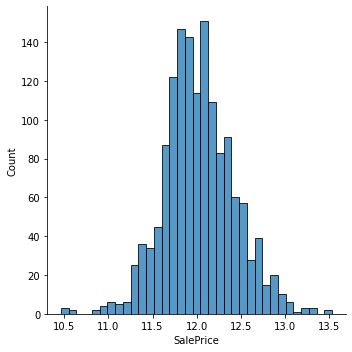

In [693]:
y = np.log(y)
sb.displot(data, x = y)
data["SalePrice"] = y

26


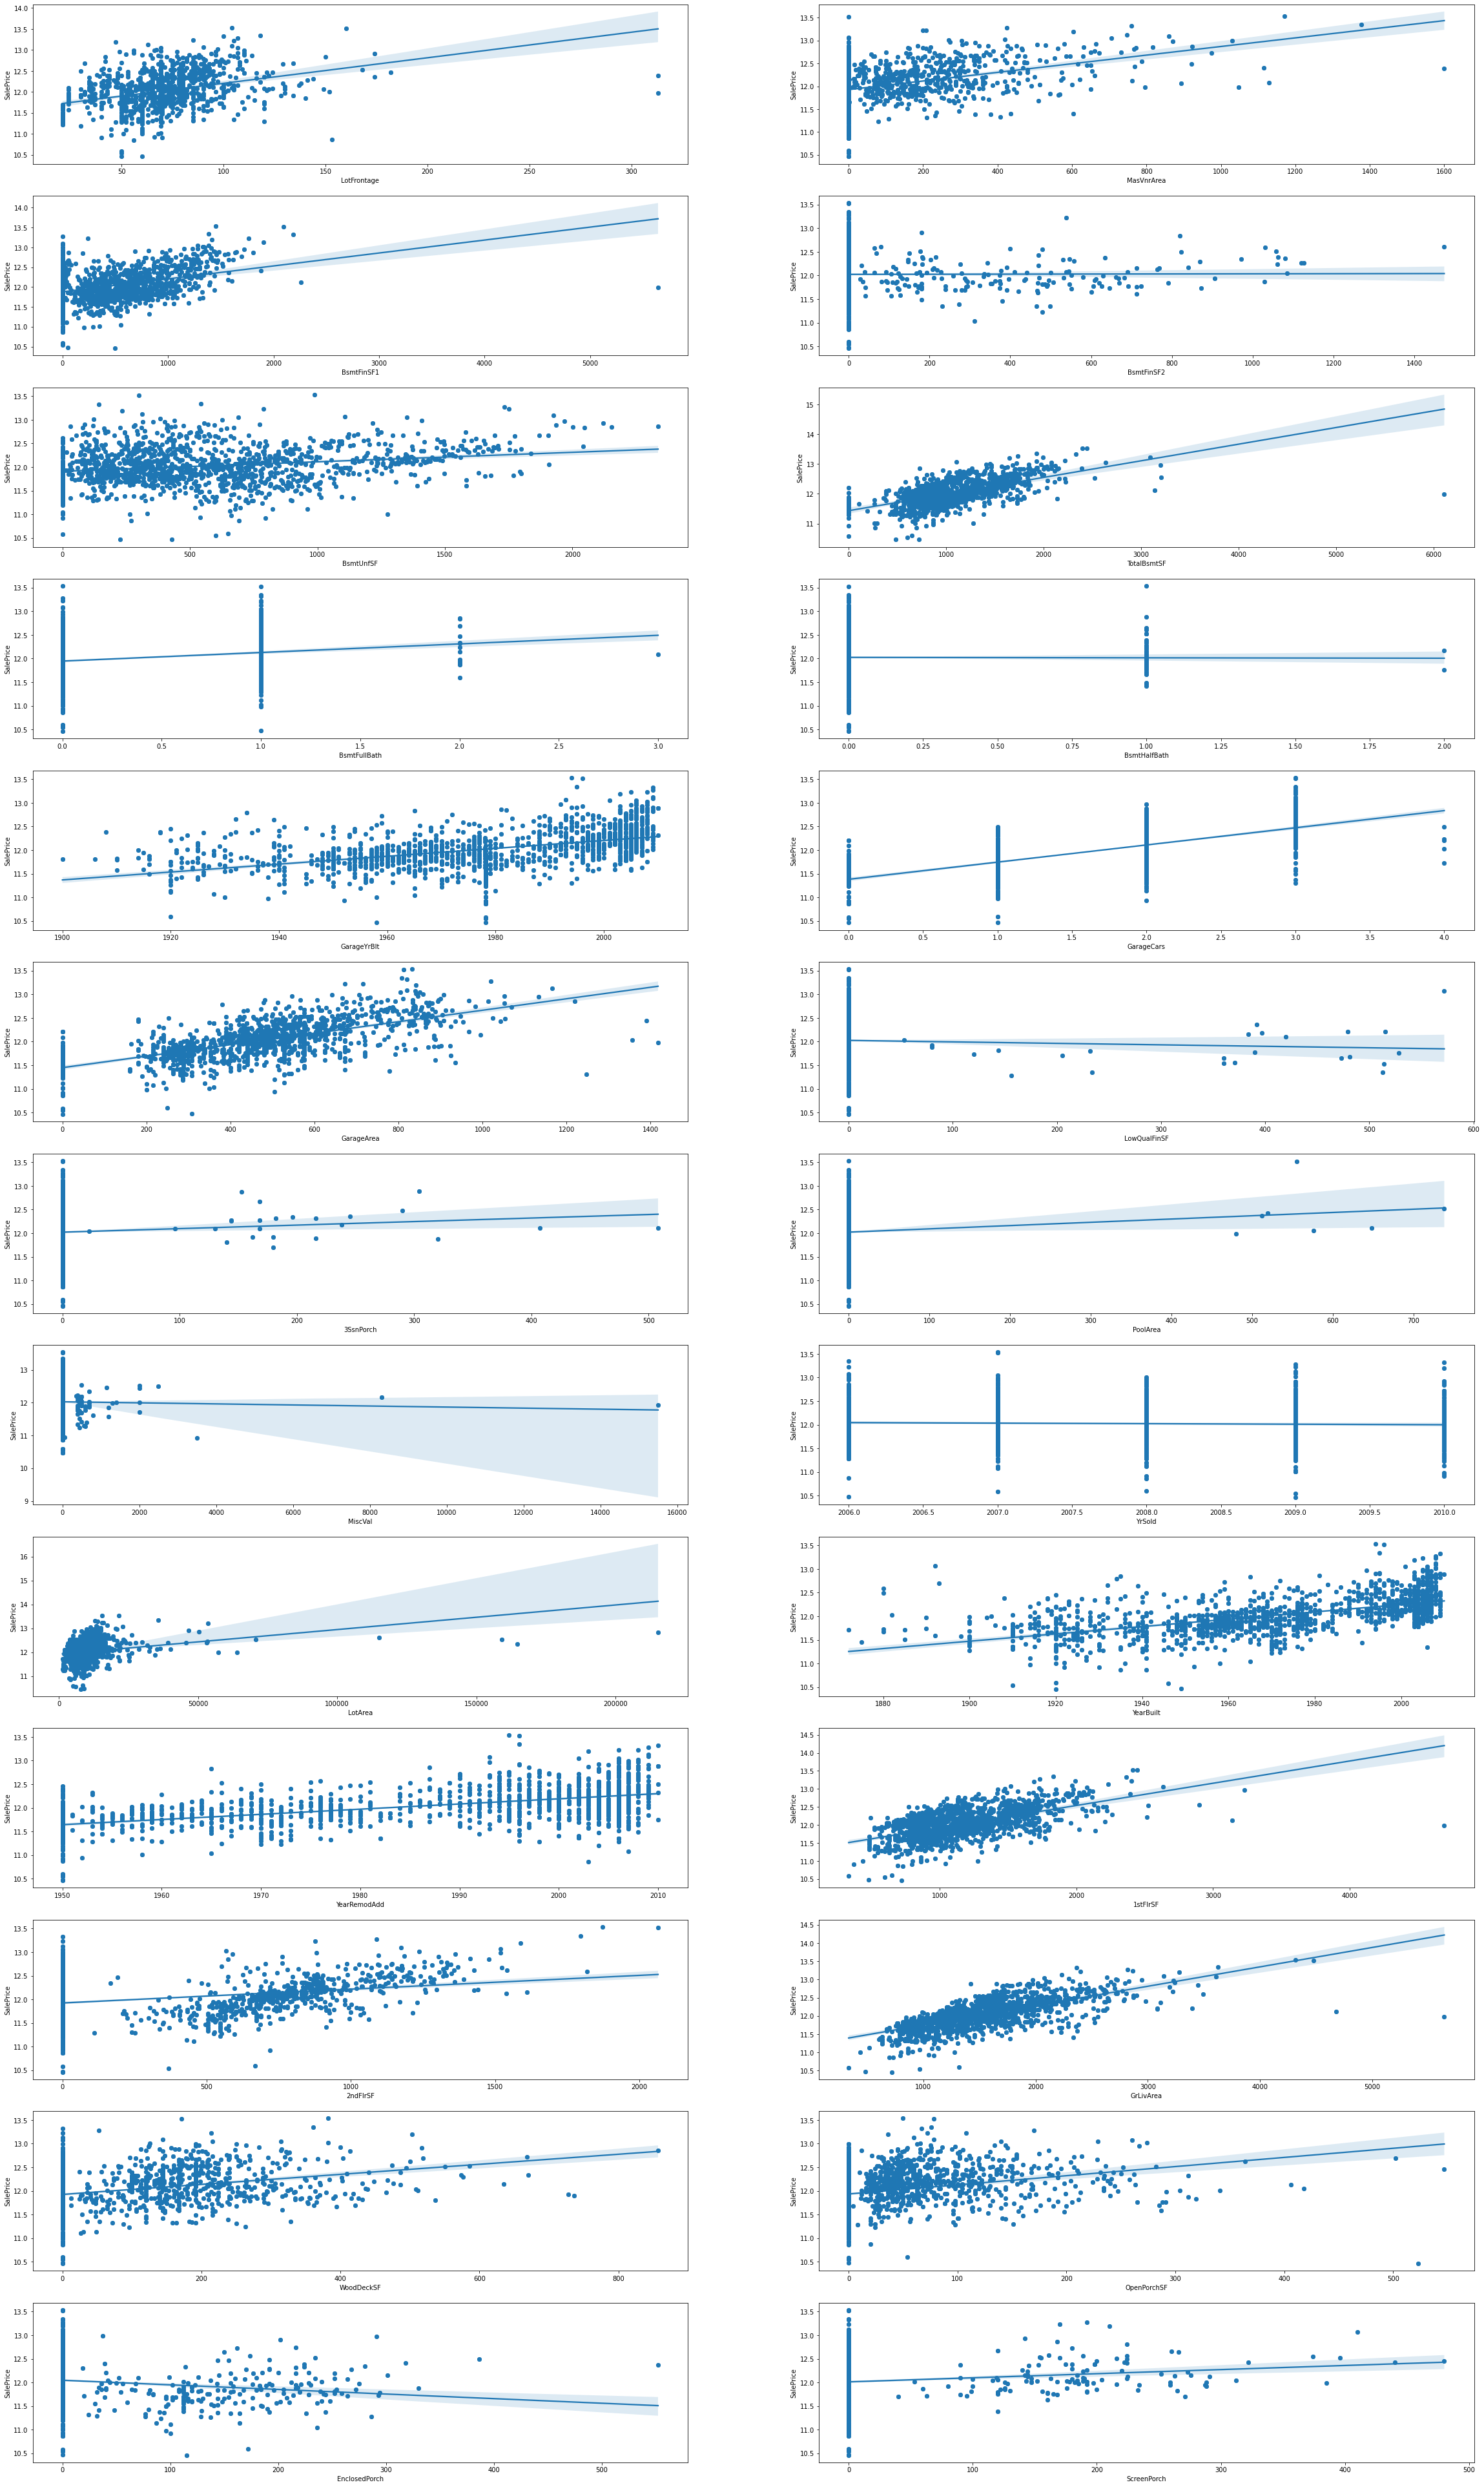

In [695]:
c = 1
fig = mpl.pyplot.figure(figsize=(40,70))
print(len(continuas))
for feature in continuas:
    mpl.pyplot.subplot(13,2,c)
    mpl.pyplot.xlabel(feature)
    mpl.pyplot.ylabel('SalePrice')
    sb.regplot(x = data[feature], y=y)
    mpl.pyplot.scatter(data[feature], y ,label = feature)
    c = c + 1

Con estas gráficas vemos que casi todas las variables numéricas parecen ser buenas predictoras, salvo:
- BsmtFinSF2
- YrSold
- PoolArea



Ahora vemos comos lucen las variables categóricas.

In [ ]:
for feature in nominales:
    print(feature)
    data[[str(feature),'SalePrice']].groupby(feature).agg({'mean','max','min'}).plot.bar()
for feature in ordinal:
    print(feature)
    data[[str(feature),'SalePrice']].groupby(feature).agg({'mean','max','min'}).plot.bar()


De acá vemos, que además de que la variable MoSold ya tenía poco sentido, parace no tener mayor relación con el modelo
ya que no se ve diferencias significativas entre las distintas categorías. Esta variable es candidata a ser removida del modelo.


In [ ]:
print(continuas)
correlaciones = target[continuas].corr()
correlaciones.shape

Como es era esperado, la matriz de correlaciones es de 23x23. 
Como resulta díficil visualizar la matriz de correlaciones se construye una visualización utilizando la biblioteca
seaborn.

<AxesSubplot:>

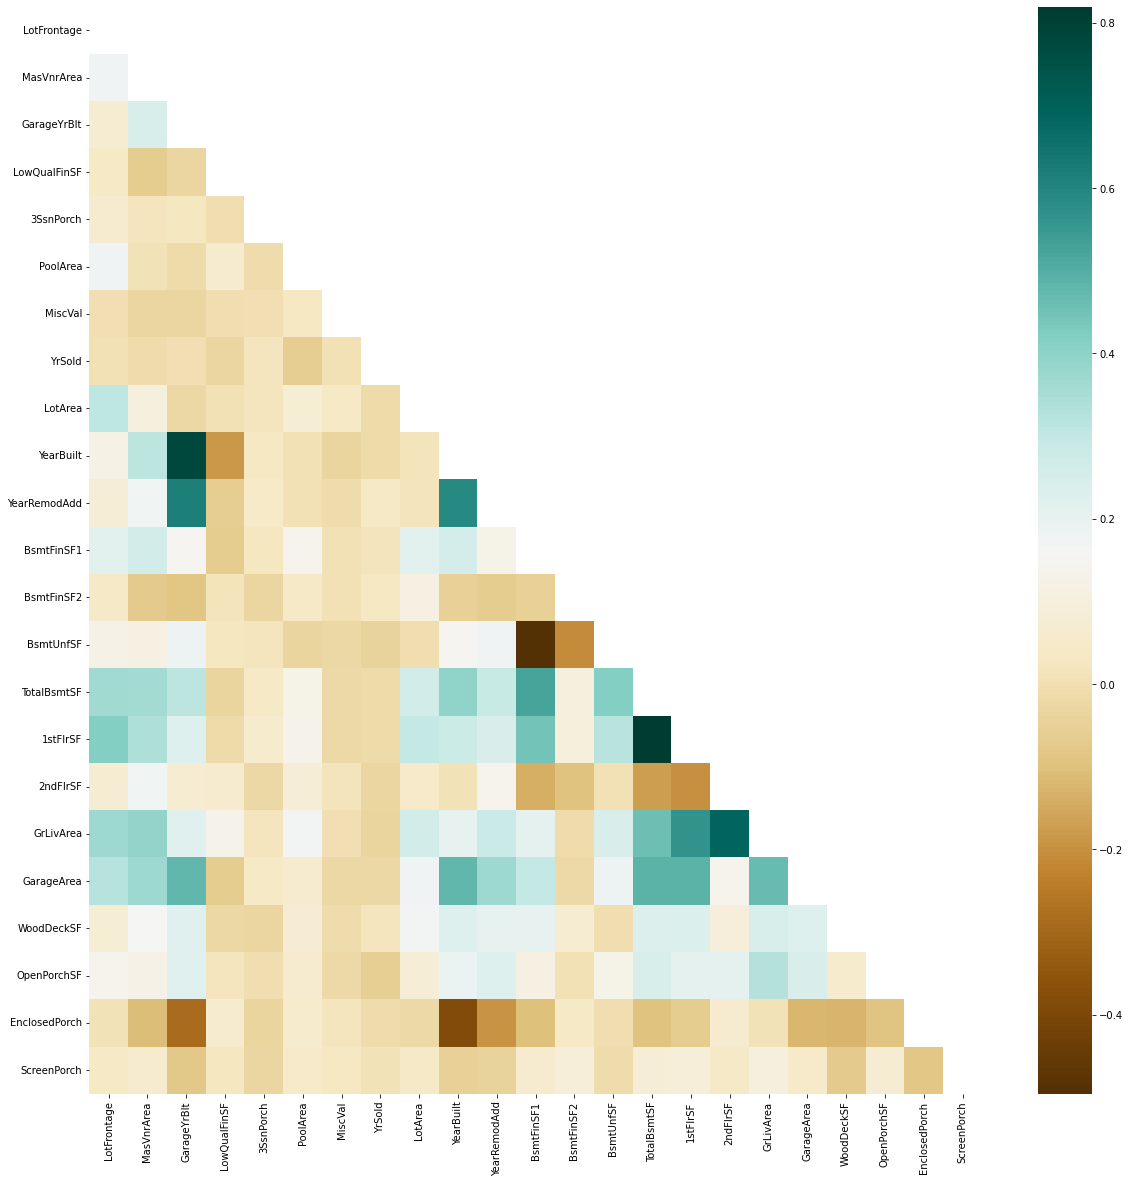

In [696]:
mask = np.triu(np.ones_like(correlaciones, dtype="bool"))
_, ax = mpl.pyplot.subplots(figsize=(20,20))
sb.heatmap(correlaciones, mask=mask, cmap='BrBG', ax = ax)

Se observan variables fuertemente correlacionadas.
Con correlación positiva:
- YearBuilt y GarageYrBlt y YearRemodAdd
- YearRemodAdd y YearBuilt
- 1stFlrSF1 y TotalBsmtSF: Total square feet of basement area

Con correlación negativa:

- BsmtUnfSF y BsmTFinSF1
- EnclosedPorch y GarageYrBlt
- EnclosedPorch y YearBuilt

## 3. Preparación de datos finales
En esta parte agregamos las variables dummies y se plantea la remoción final de algunos features
que parecen no tener mayor relación con la variable objetivo.

In [ ]:
enc = OrdinalEncoder()
enc.fit(data[ordinal])
data[ordinal] = enc.transform(data[ordinal])
print(data[ordinal].head())

In [ ]:
"""
onehot = OneHotEncoder()
onehot.fit(data)
print(onehot.categories_)
data = onehot.transform(data)
data.shape
"""
X = pd.get_dummies(data)
print(X.shape)


enc = OrdinalEncoder()
enc.fit(test_data[ordinal])
test_data[ordinal] = enc.transform(test_data[ordinal])


test_data.info()

test = pd.get_dummies(test_data)

In [ ]:
reg = LinearRegression()
reg.fit(X, y)
y_predicted = reg.predict(test)